In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd '/content/drive/MyDrive/FPT Mask /data_211/data_211/Test Code'
# !ls

/content/drive/MyDrive/FPT Mask /data_211/data_211/Test Code
'Augment using Albumentations.ipynb'   test
 Mosaic.ipynb			       utils.py
 __pycache__			       ZoomOut_CutOut_Mixup.ipynb
 requirements.txt


In [16]:
import random
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import os
import glob
import numpy as np
from PIL import Image
import string
from utils import yolo_format_to_str, find_and_remove_empty_file
import ntpath

## Tunning Parameter

In [17]:
cwd = os.getcwd()
OUTPUT_SIZE = (1080, 900)  # Height, Width
SCALE_RANGE = (0.4, 0.6) # make sure sum of two paramenter equal one
FILTER_TINY_SCALE = 0.001 # if height or width lower than this scale, drop it.
number_img = 200 # number of images, you want to generate 

# please fill full path contain images, labels
IMG_DIR = cwd + "/data_211_big/images/train/"
ANNO_DIR = cwd + "/data_211_big/labels/train/"

# please fill full path contain generated images, labels
ANNO_TARGET_DIR = cwd + '/test/mosaics_test/labels/'
IMG_TARGET_DIR = cwd + '/test/mosaics_test/images/'

if not os.path.exists(ANNO_TARGET_DIR):
    os.makedirs(ANNO_TARGET_DIR)
if not os.path.exists(IMG_TARGET_DIR):
    os.makedirs(IMG_TARGET_DIR)

In [18]:
find_and_remove_empty_file(IMG_DIR)
find_and_remove_empty_file(ANNO_DIR)

## Mosaic

In [19]:
#convert yolo format to pascal voc normalize
def yolo_convert_pascal_voc(box_yolo, h, w,label):
    a = int((box_yolo[0]*2*w - box_yolo[2]*w)/2)/w
    c = int((box_yolo[0]*2*w + box_yolo[2]*w)/2)/w
    b = int((box_yolo[1]*2*h - box_yolo[3]*h)/2)/h
    d = int((box_yolo[1]*2*h + box_yolo[3]*h)/2)/h
    return [label,a,b,c,d]

In [20]:
#convert pascal voc to yolo
def pascal_voc_convert_yolo(list_box):
    new_list_box = []
    for i, box in enumerate(list_box):
        label,a,b,c,d = list_box[i]
        bbox_tmp = [label, (a+c)/2, (b+d)/2, (c-a), (d-b)]
        new_list_box.append(bbox_tmp)
    return new_list_box

In [21]:
def get_dataset(anno_dir, img_dir):

    img_paths = []
    annos = []
    for anno_file in glob.glob(anno_dir + '*.txt'):
        anno_id = ntpath.basename(anno_file).split(".")[0]

        boxes = []
        f = open(anno_file, 'r')
        img_path = img_dir + f'{anno_id}.jpg'
        # check image exist
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            img_height, img_width, _ = img.shape
            del img
            # read from annotations file
            data = f.read()
            f.close()
            data_line_by_line = data.split("\n")
            data_line_by_line = [i for i in data_line_by_line if i != ""]
            data_line_by_line = [i.split(" ") for i in data_line_by_line]
            for i,_ in enumerate(data_line_by_line):
                tmp = data_line_by_line[i]
                tmp = [float(e) for e in tmp]
                box_descrip = tmp[1:]
                boxes.append(yolo_convert_pascal_voc(box_yolo= box_descrip, h= img_height, w= img_width,label= int(tmp[0])))

            img_paths.append(img_path)
            annos.append(boxes)
        else:
            continue
    return img_paths, annos

In [22]:
# mosaic 
def update_image_and_anno(all_img_list, all_annos, idxs, output_size, scale_range, filter_scale=0.):
    output_img = np.zeros([output_size[0], output_size[1], 3], dtype=np.uint8)
    scale_x = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    scale_y = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    divid_point_x = int(scale_x * output_size[1])
    divid_point_y = int(scale_y * output_size[0])

    new_anno = []
    for i, idx in enumerate(idxs):
        path = all_img_list[idx]
        img_annos = all_annos[idx]

        img = cv2.imread(path)
        if i == 0:  # top-left
            try:
                img = cv2.resize(img, (divid_point_x, divid_point_y))
                output_img[:divid_point_y, :divid_point_x, :] = img
                for bbox in img_annos:
                    xmin = bbox[1] * scale_x
                    ymin = bbox[2] * scale_y
                    xmax = bbox[3] * scale_x
                    ymax = bbox[4] * scale_y
                    new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
            except Exception as e:
                print(str(e))
            
        elif i == 1:  # top-right
            try:
                img = cv2.resize(img, (output_size[1] - divid_point_x, divid_point_y))
                output_img[:divid_point_y, divid_point_x:output_size[1], :] = img
                for bbox in img_annos:
                    xmin = scale_x + bbox[1] * (1 - scale_x)
                    ymin = bbox[2] * scale_y
                    xmax = scale_x + bbox[3] * (1 - scale_x)
                    ymax = bbox[4] * scale_y
                    new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
            except Exception as e:
                print(str(e))
        elif i == 2:  # bottom-left
            try:
                img = cv2.resize(img, (divid_point_x, output_size[0] - divid_point_y))
                output_img[divid_point_y:output_size[0], :divid_point_x, :] = img
                for bbox in img_annos:
                    xmin = bbox[1] * scale_x
                    ymin = scale_y + bbox[2] * (1 - scale_y)
                    xmax = bbox[3] * scale_x
                    ymax = scale_y + bbox[4] * (1 - scale_y)
                    new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
            except Exception as e:
                print(str(e))
        else:  # bottom-right
            try:
                img = cv2.resize(img, (output_size[1] - divid_point_x, output_size[0] - divid_point_y))
                output_img[divid_point_y:output_size[0], divid_point_x:output_size[1], :] = img
                for bbox in img_annos:
                    xmin = scale_x + bbox[1] * (1 - scale_x)
                    ymin = scale_y + bbox[2] * (1 - scale_y)
                    xmax = scale_x + bbox[3] * (1 - scale_x)
                    ymax = scale_y + bbox[4] * (1 - scale_y)
                    new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
            except Exception as e:
                print(str(e))

    if 0 < filter_scale:
        new_anno = [anno for anno in new_anno if
                    filter_scale < (anno[3] - anno[1]) and filter_scale < (anno[4] - anno[2])]

    return output_img, new_anno

## Generate Images

In [23]:
img_paths, annos = get_dataset(ANNO_DIR, IMG_DIR)

In [24]:
for _ in range(number_img):
    idxs = random.sample(range(len(annos)), 4)

    new_image, new_annos = update_image_and_anno(img_paths, annos,
                                                    idxs,
                                                    OUTPUT_SIZE, SCALE_RANGE,
                                                    filter_scale=FILTER_TINY_SCALE)
    
    #Convert pascal voc to yolo format
    new_annos_yolo = pascal_voc_convert_yolo(new_annos)
    random_string = ''.join(random.choices(string.ascii_lowercase + string.digits, k=20))
    name_file_anno = ANNO_TARGET_DIR + "mosaic_" + random_string
    name_file_images = IMG_TARGET_DIR + "mosaic_" + random_string
    new_annos_yolo_total = yolo_format_to_str(new_annos_yolo)
    
    #Save file annotation
    f = open( name_file_anno + ".txt", 'w')
    f.write(new_annos_yolo_total)
    f.close()

    #Save images
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    new_image = Image.fromarray(new_image.astype(np.uint8))
    new_image.save(name_file_images + ".jpg")

## Visualize Images

In [25]:
img_paths_gen, annos_gen = get_dataset(ANNO_TARGET_DIR, IMG_TARGET_DIR)

In [26]:
def scale_anno_file(anno_list, height, width):
    scale_list = []
    for anno in anno_list:
        label, a,b,c,d = anno
        scale_list.append([label, a*width, b*height, c*width, d*height])

    return scale_list

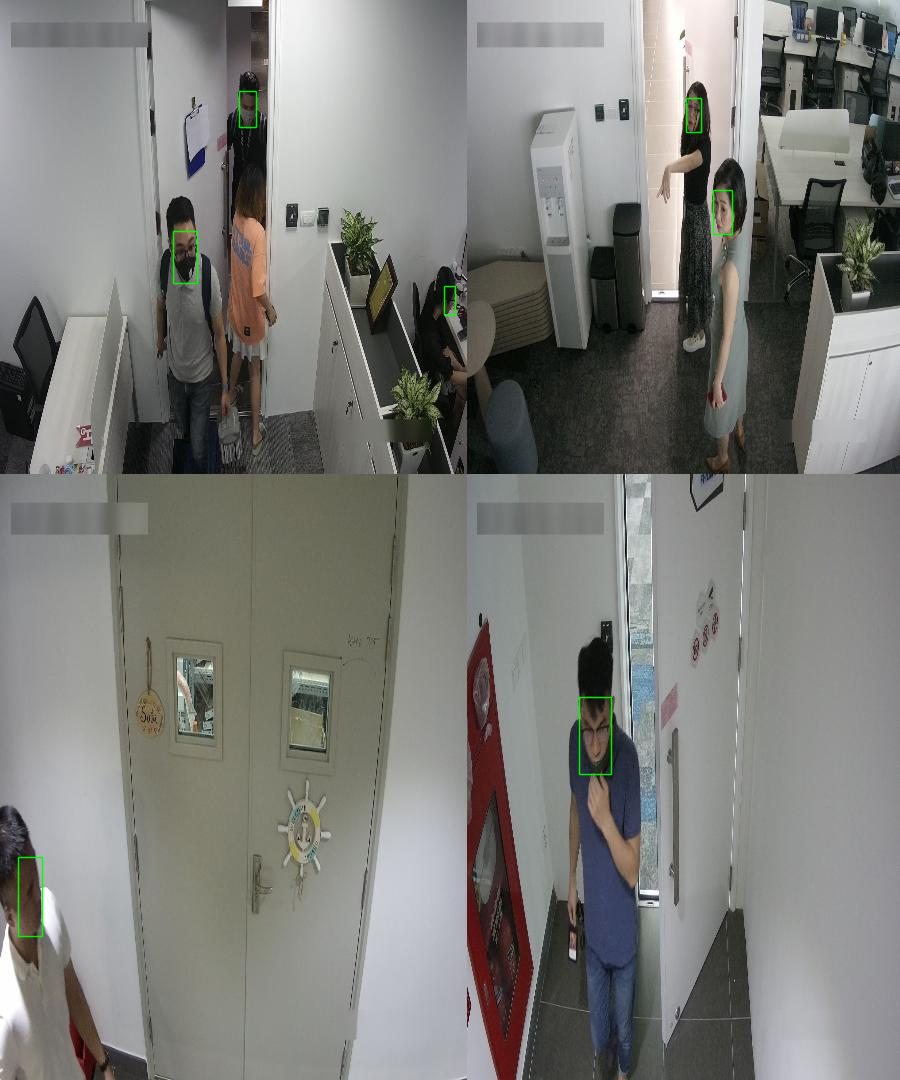

In [28]:
i = random.randint(0, len(img_paths_gen) - 1)
image = cv2.imread(img_paths_gen[i])
scale_anno = scale_anno_file(annos_gen[i], OUTPUT_SIZE[0], OUTPUT_SIZE[1])

for anno_ in scale_anno:
    start_point = (int(anno_[1]), int(anno_[2]))
    end_point = (int(anno_[3]), int(anno_[4]))
    cv2.rectangle(image, start_point, end_point, (0, 255, 0), 1, cv2.LINE_AA)

new_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
new_image = Image.fromarray(new_image.astype(np.uint8))
new_image